In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing the protein data
k2 = []
k2d = []

f = open("../../../../../../Data/Proteins/DENV2/PrM/DENV2_Premembrane.txt", "r")
for x in f:
    if "DSS" in x:
        k2d.append(1)
    elif "DHF" in x:
        k2d.append(1)
    elif x[0] == ">":
        k2d.append(0)
    else:
        x = x.replace("\n", "")
        k2.append(x)

In [3]:
# Converting the array into DataFrame
k2 = pd.DataFrame(k2)

# Attaching the "Disease" label column to the input
k2["Disease"] = k2d

# Renaming the columns
k2 = k2.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})

In [4]:
print("The combined shape of the given data is:", str(k2.shape))
print("The length of the combined data is:", str(len(k2.index)))
print("Does the combined data have any null value? ->", k2.isnull().values.any())

k2 = k2.dropna(how = 'any', axis = 0) 

# Shuffling the data and then taking a peek
k2 = k2.sample(frac = 1)
print(k2.head())

The combined shape of the given data is: (603, 2)
The length of the combined data is: 603
Does the combined data have any null value? -> False
                                              Sequence  Disease
273  FHLTTRNGEPHMIVGRQEKGKSLLFKTEDGVNMCTLMAIDLGELCE...        0
449  FHLTTRNGEPHMIVGRQEKGKSLLFKTEDGVNMCTLMAIDLGELCE...        1
367  FHLTTRNGEPHMIVGIQEKGKSLLFKTEDGVNMCTLMAMDLGELCE...        0
63   FHLTTRNGEPHMIVGRQEKGKSLLFKTEDGVNMCTLMAIDLGELCE...        0
92   FHLTTRNGEPHMIVGRQEKGKSLLFKTEDGVNMCTLMAIDLGELCE...        0


In [5]:
# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 6):
    return [sequence[x:x + size].lower() for x in range(len(sequence) - size + 1)]

k2['words'] = k2.apply(lambda x: getKmers(x['Sequence']), axis = 1)
k2 = k2.drop('Sequence', axis=1)

k2_texts = list(k2['words'])
for item in range(len(k2_texts)):
    k2_texts[item] = ' '.join(k2_texts[item])

The shape of y is: (603,)


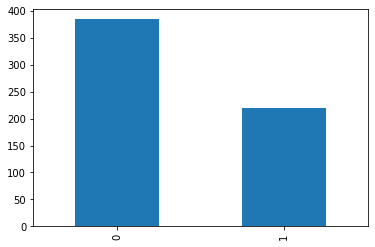

In [6]:
# Creating y and printing the shape of it
y = k2.iloc[:, 0].values
print("The shape of y is:", y.shape)

# Checking the balance of the disease severity
k2["Disease"].value_counts().sort_index().plot.bar()

In [7]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
x = cv.fit_transform(k2_texts)

# Print the shape of x
print("The shape of x matrix is:", x.shape)

The shape of x matrix is: (603, 657)


In [8]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

# Printing the shapes of the train and test matrices
print("The shape of x_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of x_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)

The shape of x_train is: (482, 657)
The shape of y_train is: (482,)
The shape of x_test is: (121, 657)
The shape of y_test is: (121,)


## AdaBoost

In [9]:
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("\naccuracy = {} \nprecision = {} \nrecall = {} \nf1 = {}".format(accuracy, precision, recall, f1))

Confusion matrix
Predicted   0   1
Actual           
0          71  10
1          15  25

accuracy = 0.7933884297520661 
precision = 0.7887894346668131 
recall = 0.7933884297520661 
f1 = 0.7895943649890301
